In [1]:
import glob
import os
import random
import shutil
import sys
from pathlib import Path

import numpy as np
import scipy.io
import torch

current_dir = os.path.dirname(os.path.abspath("__file__"))  # 当前目录
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))  # 上一级目录
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, ".."))  # 上两级目录
sys.path.append(grandparent_dir)

import data_function
import metrics
import tools
import utils
from ex_main.model import *
from ex_main.train_dataloader import getData
from utils.config_plot import *

In [2]:
ppath = "/home/hy/project/reid_task/ex_main/"

# Config
config_file_path = os.path.join(ppath, "config.py")
config = utils.common.read_config_file(config_file_path)

# Initialize a logger tool
logger = utils.logger.Logger(config.outputs_path)
logger.info("#" * 50)
logger.info(f"Task: {config.taskname}")
logger.info(f"Using device: {config.device}")
logger.info(f"Using data type: {config.dtype}")

# Set environment
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)
torch.cuda.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # The result cannot be reproduced when True

# Outputs path
vis_outputs_path = "./results/vis/"
if os.path.exists(vis_outputs_path):
    shutil.rmtree(vis_outputs_path)

2024-07-08 01:54:34 INFO ##################################################
2024-07-08 01:54:34 INFO Task: ReID_Task
2024-07-08 01:54:34 INFO Using device: cuda
2024-07-08 01:54:34 INFO Using data type: torch.float32


In [3]:
# Data
config.test_batch_size = 2
train_loader, query_loader, gallery_loader, num_classes = getData(config=config)

# Model
model = ReidNet(num_classes=num_classes, config=config, logger=logger).to(config.device)
path = os.path.join(ppath, "outputs/models/model_155.tar")
utils.network.load_network(model, path, config.device)
print("done.")

Successfully loaded pretrained weights from "/home/hy/project/reid_task/ex_main/outputs/models/model_155.tar"
done.


In [4]:
import argparse
import os.path as osp

import cv2
import numpy as np
import torch
import utils
from torch.nn import functional as F

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
GRID_SPACING = 10


@torch.no_grad()
def visactmap(
    model, test_loader, save_dir, width, height, use_gpu, img_mean=None, img_std=None
):
    if img_mean is None or img_std is None:
        # use imagenet mean and std
        img_mean = IMAGENET_MEAN
        img_std = IMAGENET_STD

    model.eval()

    for target in list(["dataset"]):
        # data_loader = test_loader[target]["query"]  # only process query images
        # original images and activation maps are saved individually
        actmap_dir = save_dir
        utils.common.mkdir_if_missing(actmap_dir)
        print("Visualizing activation maps for {} ...".format(target))

        for batch_idx, data in enumerate(test_loader):
            imgs, pids, camids, paths = data
            if use_gpu:
                imgs = imgs.cuda()
                pids = pids.cuda()

            # forward to get convolutional feature maps
            try:
                outputs = model.backbone(imgs)

            except TypeError:
                raise TypeError(
                    "heatmap got unexpected keyword method, return feature maps only."
                )

            if outputs.dim() != 4:
                raise ValueError(
                    "The model output is supposed to have "
                    "shape of (b, c, h, w), i.e. 4 dimensions, but got {} dimensions. "
                    "Please make sure you set the model output at eval mode "
                    "to be the last convolutional feature maps".format(outputs.dim())
                )

            # compute activation maps
            # outputs = (outputs**2).sum(1)

            # outputs = torch.abs(outputs)
            # outputs = outputs.sum(1)

            # outputs = torch.abs(outputs)
            # outputs = torch.max(outputs, dim=1, keepdim=True)[0]
            # outputs = outputs.squeeze_(1)

            classifier_params = list(
                model.classifier_head.classifier.named_parameters()
            )[-1]
            params_selected = classifier_params[1]
            outputs = torch.einsum(
                "bc, bcij -> bij", params_selected[pids], outputs
            ).detach()

            b, h, w = outputs.size()
            outputs = outputs.view(b, h * w)
            outputs = F.normalize(outputs, p=2, dim=1)
            outputs = outputs.view(b, h, w)

            if use_gpu:
                imgs, outputs = imgs.cpu(), outputs.cpu()

            for j in range(outputs.size(0)):
                # get image name
                path = paths[j]
                imname = osp.basename(osp.splitext(path)[0])

                # RGB image
                img = imgs[j, ...]
                for t, m, s in zip(img, img_mean, img_std):
                    t.mul_(s).add_(m).clamp_(0, 1)
                img_np = np.uint8(np.floor(img.numpy() * 255))
                img_np = img_np.transpose((1, 2, 0))  # (c, h, w) -> (h, w, c)

                # activation map
                # outputs[j, :2, :] = 0
                # outputs[j, -2:, :] = 0
                # outputs[j, :, :2] = 0
                # outputs[j, :, -2:] = 0
                am = outputs[j, ...].numpy()
                # am = outputs[j, 2:-2:, 2:-2].numpy()
                am = cv2.resize(am, (width, height))
                am = 255 * (am - np.min(am)) / (np.max(am) - np.min(am) + 1e-12)
                am = np.uint8(np.floor(am))
                am = cv2.applyColorMap(am, cv2.COLORMAP_JET)

                # return img_np, am, outputs

                # overlapped
                overlapped = img_np * 0.4 + am * 0.6
                overlapped[overlapped > 255] = 255
                overlapped = overlapped.astype(np.uint8)

                # save images in a single figure (add white spacing between images)
                # from left to right: original image, activation map, overlapped image
                grid_img = 255 * np.ones(
                    (height, 3 * width + 2 * GRID_SPACING, 3), dtype=np.uint8
                )
                grid_img[:, :width, :] = img_np[:, :, ::-1]
                grid_img[:, width + GRID_SPACING : 2 * width + GRID_SPACING, :] = am
                grid_img[:, 2 * width + 2 * GRID_SPACING :, :] = overlapped
                cv2.imwrite(osp.join(actmap_dir, imname + ".jpg"), grid_img)
                plt.figure()  # del --
                plt.imshow(grid_img[:, :, ::-1])  # del --

            if (batch_idx + 1) % 10 == 0:
                print("- done batch {}/{}".format(batch_idx + 1, len(test_loader)))
                return  # del --

Visualizing activation maps for dataset ...
- done batch 10/6468


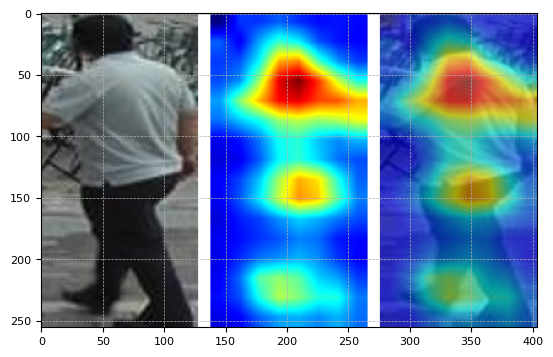

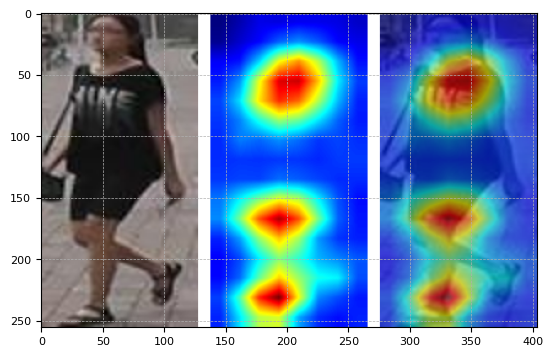

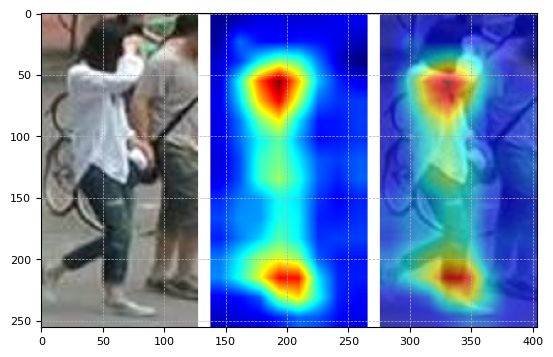

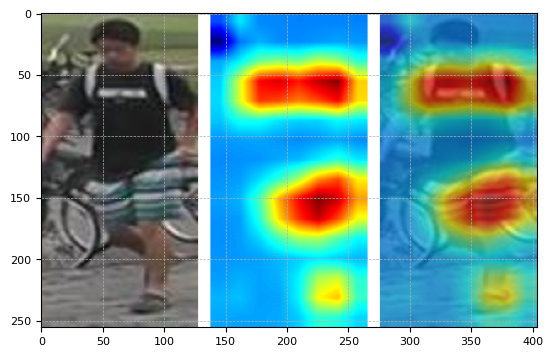

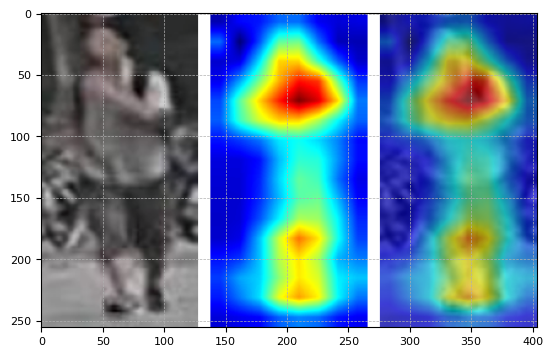

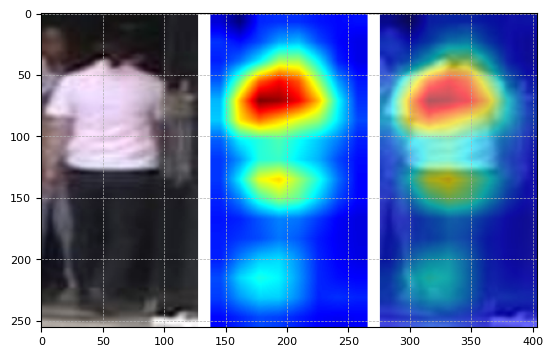

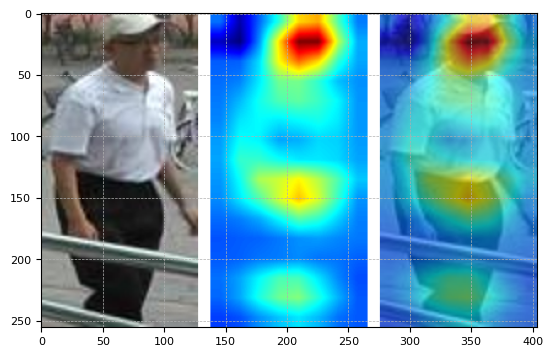

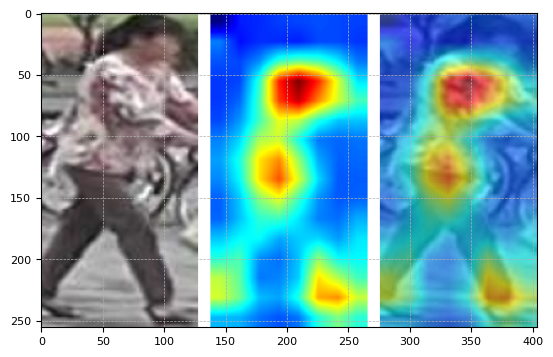

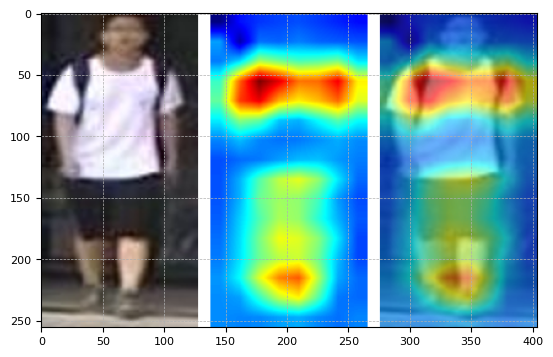

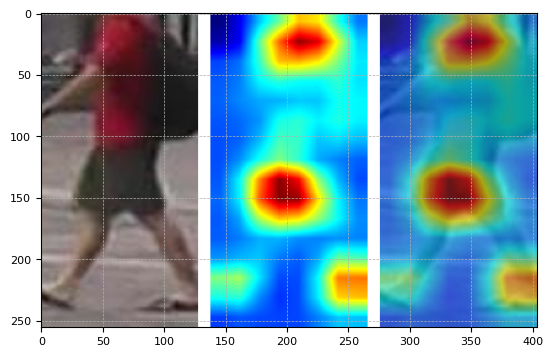

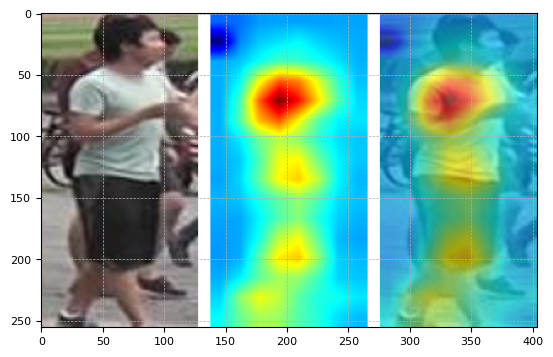

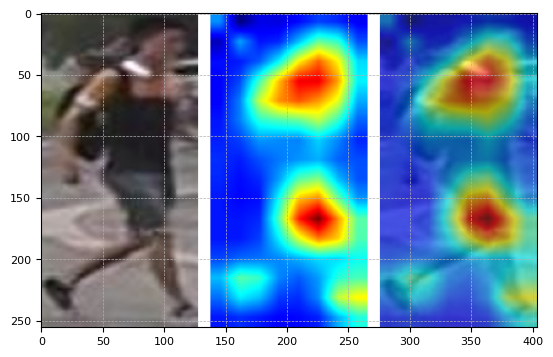

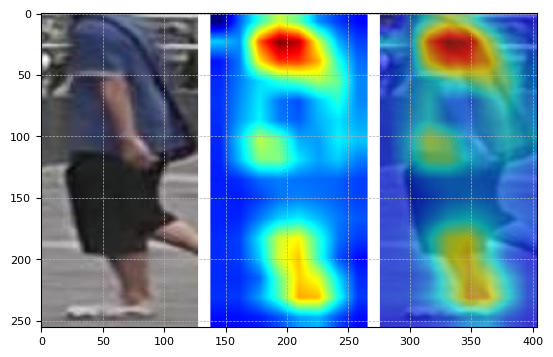

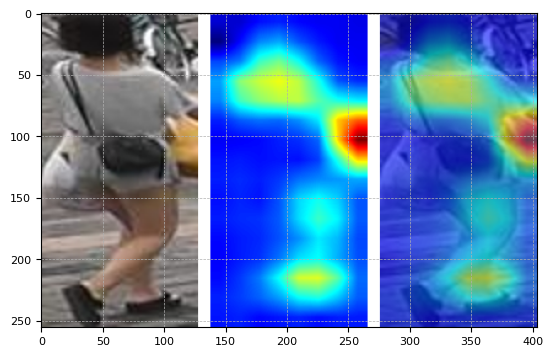

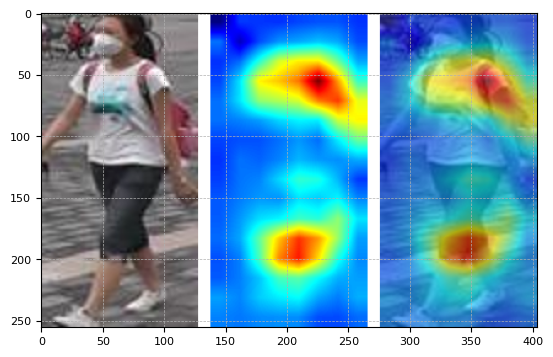

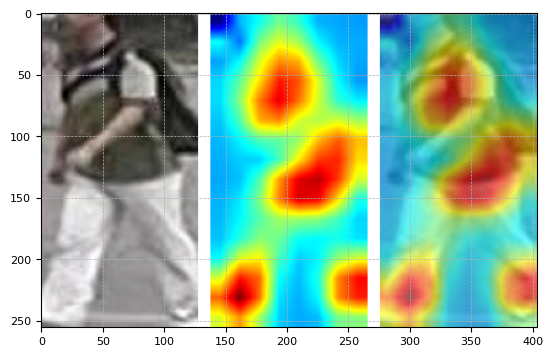

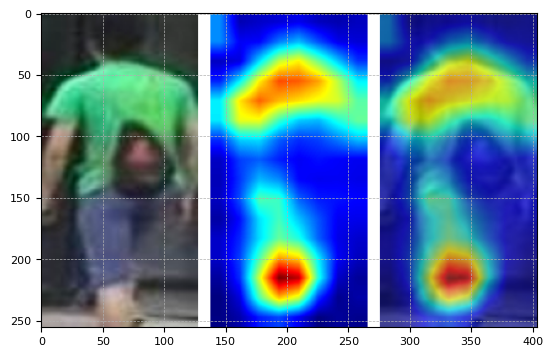

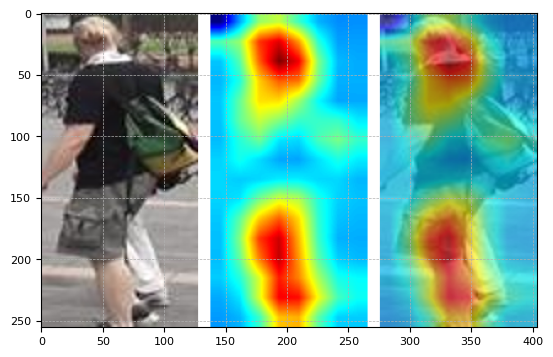

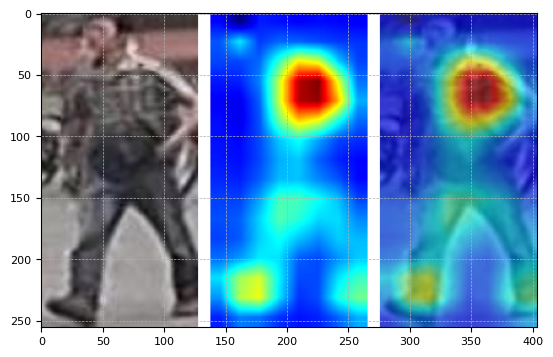

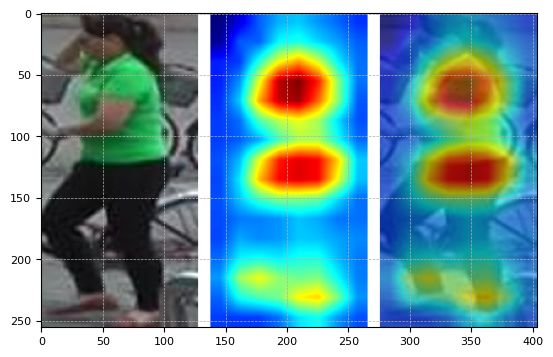

In [5]:
import torchvision.transforms as T


def val_collate_fn(batch):
    imgs, pids, camids, impath = zip(*batch)
    pids = torch.tensor(pids, dtype=torch.int64)
    return torch.stack(imgs, dim=0), pids, camids, impath


train_transforms = T.Compose(
    [
        T.Resize((config.img_height, config.img_width), interpolation=3),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

dataset = data_function.datasets.Market1501(root=config.dataset_path)
train_set = data_function.ImageDataset(dataset.train, train_transforms)
hmap_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=config.test_batch_size,
    shuffle=False,
    collate_fn=val_collate_fn,
)


visactmap(
    model,
    hmap_loader,
    os.path.join(vis_outputs_path, "hmap"),
    width=config.img_width,
    height=config.img_height,
    use_gpu=True,
)